<a href="https://colab.research.google.com/github/SNOOthiking/SHOPPING/blob/snoo/W2V_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon 쇼핑몰 리뷰 평점 분류 경진대회 - Word2Vec 1. 긍정과 부정 두 군으로 나눠보자
****
- word2vec은 2013년에 만들어진 자연어 처리기술로 신경망 모델을 사용하여 단어 연관성을 학습합니다. 
- 단어의 연관성을 이용해 부정적 단어와 긍정적 언어를 분류해 분류학습을 시도한다면 평점 분석을 할 수 있지 않을까? 에서 시작했습니다. 


## 모듈 임포트

In [25]:
import pandas as pd  
import re            # 정규표현식 내장 모듈 (언어 전처리)
import nltk          # Natural Language Toolkit 자연어 처리 라이브러리 (한국어에는 좋지 못함)
import numpy as np   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # 검증용 스플릿
from sklearn.linear_model import LogisticRegression  # 로지스틱회귀로 분류진행

In [4]:
nltk.download('punkt') # 문장을 분리해주는 툴킷 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 코랩 드라이브 연결

In [6]:
from google.colab import drive
from os.path import join

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [8]:
train = pd.read_csv('/content/drive/MyDrive/dacon_shopping/shopping_git/dataset/train.csv')

In [9]:
train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


## 데이터 확인

In [10]:
print((train.target==1).sum())
print((train.target==2).sum())
print((train.target==3).sum())
print((train.target==4).sum())
print((train.target==5).sum())

4500
8000
0
2500
10000


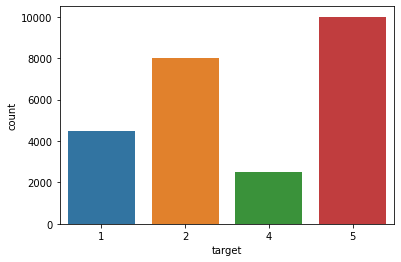

In [28]:
sns.countplot(data=train,x='target')

## 긍정과 부정 두 개로 분류해보기

In [29]:
train['target'] = train['target'].replace(4,5).replace(1,2)
train['target'].unique()

array([2, 5])

- train/val data set 분리

In [30]:
train_data, val_data = train_test_split(train, test_size=0.25, 
                                        stratify = train.target,
                                        random_state =0) # 25프로로 설정

In [31]:
# 전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
train_data = train_data.reset_index().drop('index', axis=1)
val_data = val_data.reset_index().drop('index', axis=1)
print(train_data.shape)
print(val_data.shape)

(18750, 3)
(6250, 3)


In [32]:
# training 데이터에서 변수 추출
train_X = train_data.reviews
train_y = train_data.target 

# validation 데이터에서 변수 추출
val_X = val_data.reviews
val_y = val_data.target 

- nltk word_tokenize로 문장을 구분

In [33]:
nltk.word_tokenize(train_X[0])

['재구매', '항상', '배송도', '빠르고', '물건도', '파손없고', '만족합니다~', '!']

- 단어 전처리 (특수 문자 제거)

In [34]:
delet = [] 
for i in range(len(train_X)):
    delet.append(re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·  ]',' ',train_X[i]))

In [35]:
train_token = []
for i in range(len(delet)):
    train_token.append(nltk.word_tokenize(delet[i]))


In [36]:
train_token[:3]

[['재구매', '항상', '배송도', '빠르고', '물건도', '파손없고', '만족합니다'],
 ['갠찮네요',
  '아직',
  '사용전이라',
  '잘모르겠지만',
  '스위치',
  '켜고',
  '끄는게',
  '많이',
  '힘이드네요',
  '그거말고는',
  '갠찮은듯',
  '합니다'],
 ['길이감도', '딱', '좋고', '부드럽고', '싼티안나요', '완전', '편합니다']]

## Word2Vec 학습
- train_X의 토큰인 train_token으로 학습합니다.

In [37]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors 

In [41]:
model = Word2Vec(sentences = train_token, # train_X 토큰 
                     size=100,      # 임베딩된 벡터 차원 
                     window=10,             # 컨텍스트 윈도우 크기
                     min_count=5,          # 5번 이하는 X 
                     workers=40,           # 학습 프로세스 수 
                     sg=1)                 # 0= CBOW, 1= Skip-Gram
                                           # skipgram = 중심단어로 주변단어 예측 

In [42]:
model.wv.most_similar('좋아요')

[('좋네요', 0.9958661794662476),
 ('좋고', 0.9933687448501587),
 ('편하고', 0.9927366971969604),
 ('튼튼하고', 0.9920928478240967),
 ('ㅎㅎ', 0.9919450283050537),
 ('깔끔하고', 0.9905712604522705),
 ('좋습니다', 0.9904485940933228),
 ('아주', 0.9904094338417053),
 ('가볍고', 0.9903419613838196),
 ('저렴하고', 0.9898397326469421)]

In [43]:
model.wv.most_similar('안좋아요')

[('심하네요', 0.9988831281661987),
 ('비닐', 0.9988766312599182),
 ('실망이', 0.9988532066345215),
 ('볼트', 0.9988212585449219),
 ('나머지', 0.9988073706626892),
 ('어렵고', 0.9988020062446594),
 ('봅니다', 0.9987609386444092),
 ('반품은', 0.9987536668777466),
 ('3개', 0.9987514019012451),
 ('맛없어요', 0.9987325668334961)]

- 피쳐 벡터 구하는 함수

In [50]:
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features),dtype=np.float32)

    num_words = 0
    index2word_set = set(model.wv.index2entity)
    for w in words:
        if w in index2word_set:
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[w])
    return feature_vector

In [51]:
def get_dataset(reviews, model, num_features):
    dataset = list()

    for s in reviews:
        dataset.append(get_features(s, model, num_features))

    reviewFeatureVecs = np.stack(dataset)
    
    return reviewFeatureVecs


- get_dataset함수로 피쳐벡터를 받아와 logistic에 x값으로

In [53]:
x_train_w = get_dataset(train_token,model,100)
x_train_w

array([[ 1.730446  , -0.0347609 , -0.6337145 , ..., -2.1754978 ,
        -0.711315  ,  0.25981483],
       [ 0.48081818, -0.2948311 , -0.14910376, ..., -0.8168597 ,
        -0.5548178 , -0.02469504],
       [ 1.2165412 , -0.1827519 , -0.36153078, ..., -1.4055873 ,
        -0.6529801 ,  0.31902006],
       ...,
       [ 0.5152525 , -0.13851918, -0.2232444 , ..., -0.85076255,
        -0.33754438,  0.06405606],
       [ 0.45328104, -0.289078  , -0.18388121, ..., -0.70359564,
        -0.4906777 ,  0.10596722],
       [ 0.8530009 , -0.28553218, -0.26148805, ..., -1.0866082 ,
        -0.6123393 ,  0.23743804]], dtype=float32)

In [54]:
lr = LogisticRegression(max_iter=10000)

In [55]:
lr.fit(x_train_w,train_y)

LogisticRegression(max_iter=10000)

- Validation 데이터 작업

In [56]:
delet_v = [] 
for i in range(len(val_X)):
    delet_v.append(re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·  ]',' ',val_X[i]))

In [57]:
val_token = []
for i in range(len(delet_v)):
    val_token.append(nltk.word_tokenize(delet_v[i]))


In [58]:
x_val_w = get_dataset(val_token,model,100)

# 정확도 판단 
- 생각보다 높진 않았다. 

In [59]:
(lr.predict(x_val_w) == val_y).mean()

0.80992

In [60]:
train_all = []
for i in range(len(train['reviews'])):
    train_all.append(re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·  ]',' ',train['reviews'][i]))

In [61]:
all_token = []
for i in range(len(train_all)):
    all_token.append(nltk.word_tokenize(train_all[i]))


In [62]:
len(all_token)

25000

In [63]:
test = pd.read_csv('/content/drive/MyDrive/dacon_shopping/shopping_git/dataset/test.csv')

In [64]:
test['reviews']

0                                           채소가 약간 시들어 있어요
1        발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2                                 부들부들 좋네요 입어보고 시원하면 또 살게요
3            이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4             검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요
                               ...                        
24995                                         사용해보니 좋아요~^^
24996                   저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요..
24997    세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...
24998                                       역시 로네펠트!! 좋아요.
24999    데싱 디바 써보고 갠찮아서 비슷 한줄 알앗더니 완전 별로예요ㅡㅡ3000언 더주고 디...
Name: reviews, Length: 25000, dtype: object

In [65]:
test_all = []
for i in range(len(test['reviews'])):
    test_all.append(re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·  ]',' ',test['reviews'][i]))

In [66]:
test_token = []
for i in range(len(test_all)):
    test_token.append(nltk.word_tokenize(test_all[i]))

In [67]:
test_w = get_dataset(test_token,model,100)

In [68]:
pred = lr.predict(test_w)

In [71]:
pred

array([5, 2, 5, ..., 2, 5, 2])

# 긍정과 부정을 구해보았다. 다음 작업은 분류작업으로 진행해 보도록 하겠다.